In [14]:
from src.preprocessing.dataLoader_CelebA import get_siamese_dataloader
from src.ml.resNet50 import SiameseResNet

# 1. Load the data

In [20]:
IMAGE_DIR = "data/celeba/img_align_celeba"
LABEL_FILE = "data/celeba/identity_CelebA.txt"
IMG_SIZE = 224
BATCH_SIZE = 128

In [21]:
# Create Dataset and DataLoader
dataloader = get_siamese_dataloader(IMAGE_DIR, LABEL_FILE, BATCH_SIZE, IMG_SIZE, True)


Label: tensor([1.])


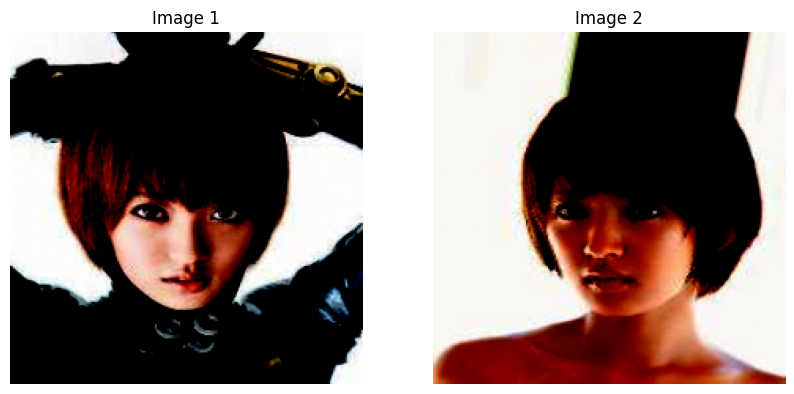

In [33]:
# Get one sample from the dataloader
dataiter = iter(dataloader)
img1, img2, label = next(dataiter)

# If you want to visualize the images, you can use matplotlib
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# For each image, we need to move the channels to the end and convert to numpy
# Assuming the images are in format (batch_size, channels, height, width)
img1_display = img1[0].permute(1, 2, 0).cpu().numpy()
img2_display = img2[0].permute(1, 2, 0).cpu().numpy()
print("\nLabel:", label[0])
# Display images
ax1.imshow(img1_display)
ax1.set_title('Image 1')
ax1.axis('off')

ax2.imshow(img2_display)
ax2.set_title('Image 2')
ax2.axis('off')

plt.show()

# Loss Function

# Create the model

In [17]:
model = SiameseResNet()

In [13]:
import torch
# Get one sample from the dataloader
dataiter = iter(dataloader)
img1, img2, label = next(dataiter)

# Move data to the same device as model
img1, img2 = img1.to(device), img2.to(device)

# Set model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    output1, output2 = model(img1, img2)

    # Calculate similarity (cosine similarity)
    cos = torch.nn.CosineSimilarity(dim=1)
    similarity = cos(output1, output2)

# Set model back to training mode
model.train()

Predicted similarity: tensor([0.3370, 0.4602, 0.7069, 0.3274, 0.2833, 0.3253, 0.3636, 0.3837, 0.5689,
        0.5962, 0.4064, 0.3100, 0.5467, 0.6328, 0.4799, 0.2978, 0.3710, 0.6354,
        0.4031, 0.4533, 0.6725, 0.4851, 0.5599, 0.2526, 0.3256, 0.4990, 0.5986,
        0.2263, 0.5258, 0.5358, 0.5286, 0.4940, 0.5051, 0.4922, 0.3156, 0.7249,
        0.3634, 0.4572, 0.5068, 0.4737, 0.7369, 0.4884, 0.6741, 0.3368, 0.5352,
        0.3912, 0.2857, 0.4423, 0.3698, 0.3178, 0.4980, 0.2994, 0.4580, 0.3862,
        0.2033, 0.6260, 0.6019, 0.5099, 0.3216, 0.5953, 0.4681, 0.6180, 0.3140,
        0.4020, 0.3712, 0.3022, 0.2574, 0.5222, 0.5247, 0.5506, 0.6590, 0.3209,
        0.3255, 0.7035, 0.1525, 0.5020, 0.6325, 0.4622, 0.4550, 0.3496, 0.5954,
        0.3083, 0.3476, 0.3523, 0.3618, 0.2915, 0.3816, 0.5739, 0.3699, 0.2655,
        0.5006, 0.3706, 0.5176, 0.4459, 0.4701, 0.5183, 0.2654, 0.5720, 0.4150,
        0.2638, 0.3746, 0.7617, 0.6856, 0.2973, 0.3666, 0.2899, 0.7590, 0.5650,
        0.2965, 0.

SiameseResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

# Train Model

# Plot the results

In [ ]:
! mlflow ui --port 5000